#### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### Data

In [2]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

#### Checking in case of Data Leak

In [3]:
test_copy = test.copy()
train_duplicate = train.drop('booking_status', axis=1)

In [4]:
test_copy = test_copy.merge(train_duplicate, on=[col for col in test_copy if col != 'id'], how='inner', suffixes=['_test', '_train'])
test_copy.head()

,id_test,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,id_train
0,42148,2,0,1,2,2,0,1,19,2018,2,26,1,0,0,0,130.00,0,6947
1,42192,2,0,1,1,0,0,0,105,2018,4,18,0,0,0,0,75.00,0,22078
2,42259,1,0,0,2,0,0,0,256,2018,6,15,1,0,0,0,115.00,1,18199
3,42400,2,0,1,1,2,0,0,301,2018,7,30,0,0,0,0,90.00,1,40245
4,42419,2,0,1,2,0,0,0,204,2017,10,10,0,0,0,0,72.75,0,11722


In [5]:
print(f"Total number of records from the test data in training data is: {test_copy.shape[0]}")

Total number of records from the test data in training data is: 716


In [6]:
train_leakage = test_copy['id_train']

In [7]:
print(train_leakage)

0       6947
1      22078
2      18199
3      40245
4      11722
       ...  
711     2699
712    23629
713    38254
714    18697
715    16679
Name: id_train, Length: 716, dtype: int64


In [8]:
# Removing the duplicate entries from the training set
train = train.drop(train_leakage).reset_index(drop=True)

In [9]:
train.shape

(41384, 19)

In [10]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


#### EDA

In [11]:
for feature in train.columns:
    print(f"{feature}: {len(train[feature].unique())}")
    print(f"{feature}: {train[feature].unique()}\n")

id: 41384
id: [    0     1     2 ... 42097 42098 42099]

no_of_adults: 5
no_of_adults: [2 1 0 3 4]

no_of_children: 6
no_of_children: [0 2 1 3 4 9]

no_of_weekend_nights: 8
no_of_weekend_nights: [0 1 2 3 5 6 4 7]

no_of_week_nights: 18
no_of_week_nights: [ 2  1  0  5  3  4  7  6  8 10 11  9 12 15 17 13 16 14]

type_of_meal_plan: 4
type_of_meal_plan: [1 0 2 3]

required_car_parking_space: 2
required_car_parking_space: [0 1]

room_type_reserved: 7
room_type_reserved: [0 2 3 1 4 5 6]

lead_time: 338
lead_time: [  9 117 315  32 258 215 320 265 189 137   1  69  50 217  58 143 188 155
 109  84   7   0 184  11 224 182 179 111  49  61 317  66  41 139 207 161
  25 147 110 208 148 223  47 275  40 129  34  94 221  51  59  95 133  12
 105 166   3 152  23  36 128  55 280  63  93  56  71 113  42 156   8  57
 160 118  30  10 132 168 198 138 107  20 159 150   6 134 172  77  33  35
 119 121 237  28 174 151 252   5 157 131 123 418 100  80 202   2  39  27
 102 122  67 196  16 245  68   4 335 178 219  14 

In [12]:
# categorical_feature
categorical_feature = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type', 'repeated_guest']

In [13]:
# Checking the dates
train_copy = train.copy()
train_copy = train_copy.groupby(['arrival_month', 'arrival_year'])

In [14]:
print("Year: 2017")
for i in range(1, 13):
    print(f"Month: {i}")
    print(f"Max: {train_copy.get_group((i, 2017))['arrival_date'].max()}")
    print(f"Min: {train_copy.get_group((i, 2017))['arrival_date'].min()}\n")

Year: 2017
Month: 1
Max: 27
Min: 18

Month: 2
Max: 28
Min: 6

Month: 3
Max: 25
Min: 14

Month: 4
Max: 29
Min: 6

Month: 5
Max: 24
Min: 2

Month: 6
Max: 24
Min: 8

Month: 7
Max: 31
Min: 1

Month: 8
Max: 31
Min: 1

Month: 9
Max: 31
Min: 1

Month: 10
Max: 31
Min: 1

Month: 11
Max: 30
Min: 1

Month: 12
Max: 31
Min: 1



In [15]:
print("Year: 2018")
for i in range(1, 13):
    print(f"Month: {i}")
    print(f"Max: {train_copy.get_group((i, 2018))['arrival_date'].max()}")
    print(f"Min: {train_copy.get_group((i, 2018))['arrival_date'].min()}\n")

Year: 2018
Month: 1
Max: 31
Min: 1

Month: 2
Max: 31
Min: 1

Month: 3
Max: 31
Min: 1

Month: 4
Max: 31
Min: 1

Month: 5
Max: 31
Min: 1

Month: 6
Max: 31
Min: 1

Month: 7
Max: 31
Min: 1

Month: 8
Max: 31
Min: 1

Month: 9
Max: 31
Min: 1

Month: 10
Max: 31
Min: 1

Month: 11
Max: 31
Min: 1

Month: 12
Max: 31
Min: 1



In [16]:
# Removing the incorrect dates from the training dataset
train.drop(index=train[(train['arrival_month'] == 1) & (train['arrival_date'] > 31)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 2) & (train['arrival_date'] > 28)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 3) & (train['arrival_date'] > 31)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 4) & (train['arrival_date'] > 30)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 5) & (train['arrival_date'] > 31)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 6) & (train['arrival_date'] > 30)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 7) & (train['arrival_date'] > 31)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 8) & (train['arrival_date'] > 31)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 9) & (train['arrival_date'] > 30)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 10) & (train['arrival_date'] > 31)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 11) & (train['arrival_date'] > 30)].index, inplace=True)
train.drop(index=train[(train['arrival_month'] == 12) & (train['arrival_date'] > 31)].index, inplace=True)

In [17]:
train.shape

(41334, 19)

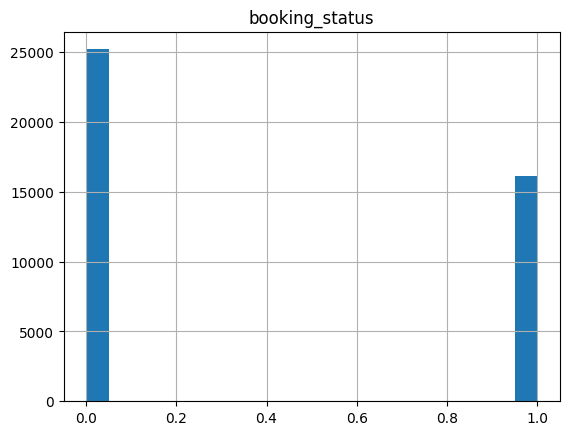

In [18]:
train['booking_status'].hist(bins=20)
plt.title("booking_status")
plt.show()

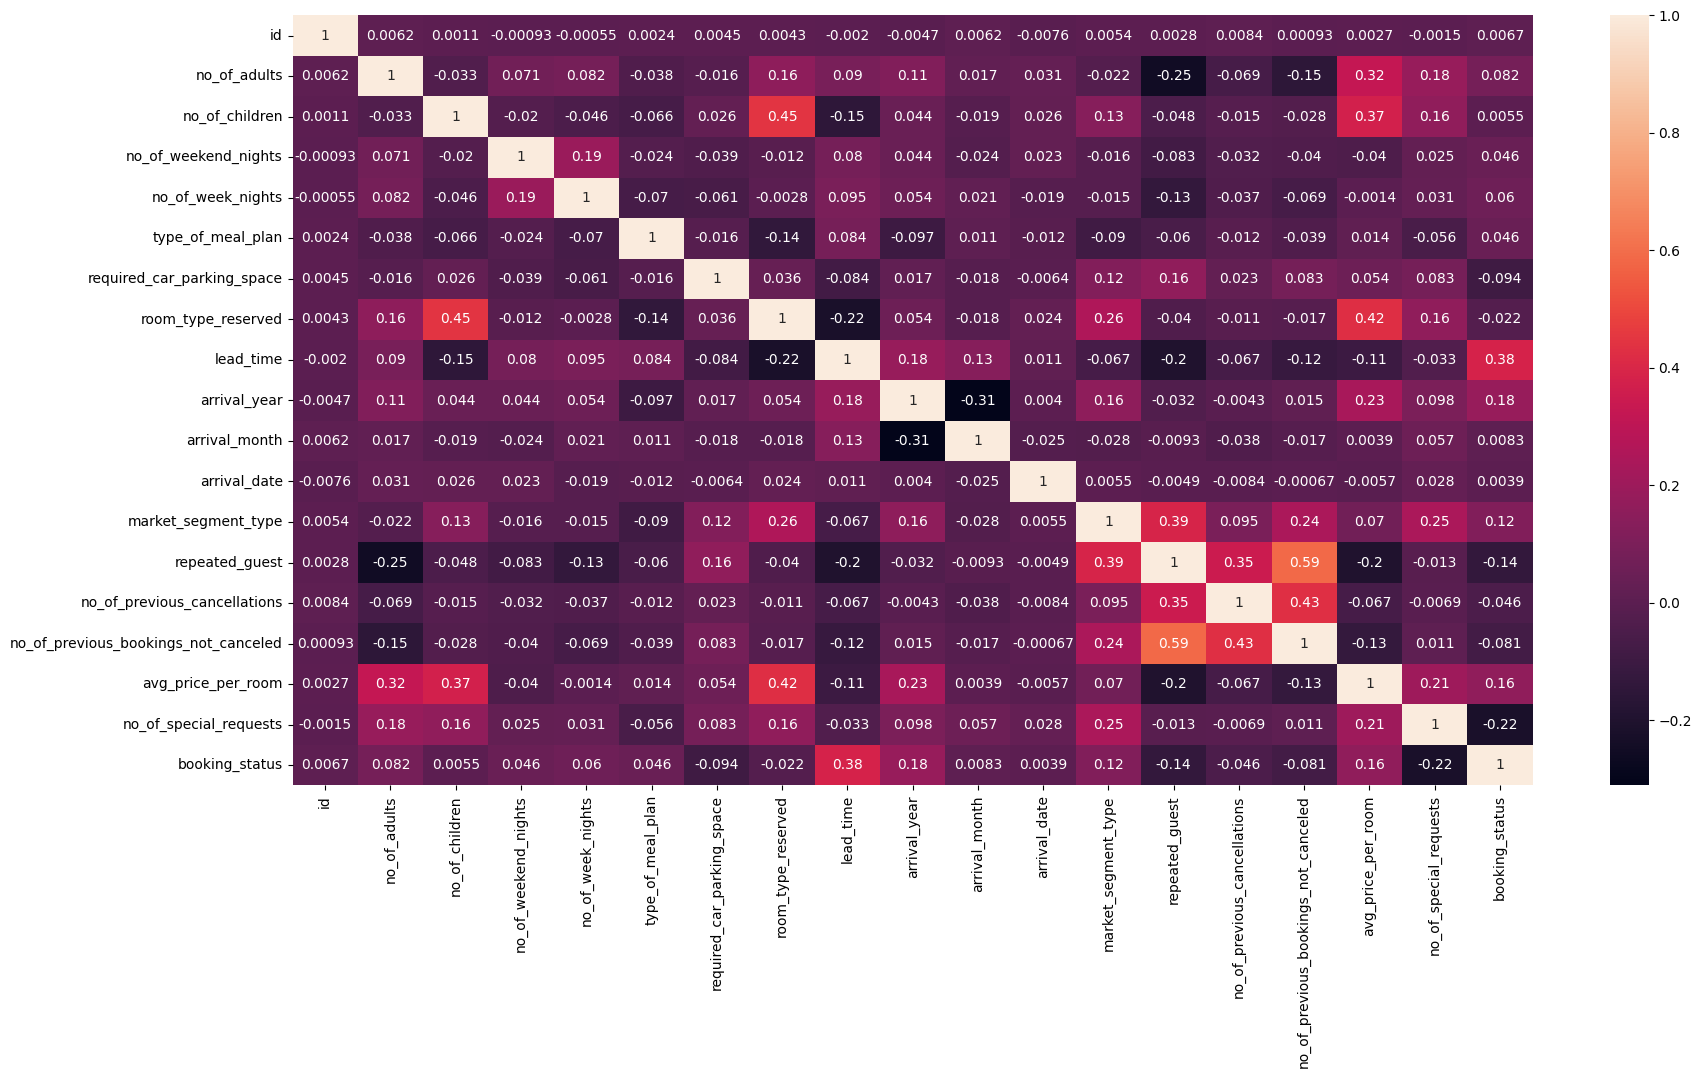

In [19]:
# Plotting the correlation
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(), annot=True)
plt.show()

In [20]:
# Checking if there are null values in the train dataset
train.isnull().sum()

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [21]:
# Checking id there are null values in the test dataset
test.isnull().sum()

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
dtype: int64

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41334 entries, 0 to 41383
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    41334 non-null  int64  
 1   no_of_adults                          41334 non-null  int64  
 2   no_of_children                        41334 non-null  int64  
 3   no_of_weekend_nights                  41334 non-null  int64  
 4   no_of_week_nights                     41334 non-null  int64  
 5   type_of_meal_plan                     41334 non-null  int64  
 6   required_car_parking_space            41334 non-null  int64  
 7   room_type_reserved                    41334 non-null  int64  
 8   lead_time                             41334 non-null  int64  
 9   arrival_year                          41334 non-null  int64  
 10  arrival_month                         41334 non-null  int64  
 11  arrival_date   

In [23]:
# Perform one hot encoding for the categorical features
from sklearn.preprocessing import OneHotEncoder

In [24]:
encoder = OneHotEncoder(sparse=False).fit(train[categorical_feature])

In [25]:
encoded_cols = list(encoder.get_feature_names_out(categorical_feature))

In [26]:
print(f"encoder_cols: {encoded_cols}")

encoder_cols: ['type_of_meal_plan_0', 'type_of_meal_plan_1', 'type_of_meal_plan_2', 'type_of_meal_plan_3', 'required_car_parking_space_0', 'required_car_parking_space_1', 'room_type_reserved_0', 'room_type_reserved_1', 'room_type_reserved_2', 'room_type_reserved_3', 'room_type_reserved_4', 'room_type_reserved_5', 'room_type_reserved_6', 'market_segment_type_0', 'market_segment_type_1', 'market_segment_type_2', 'market_segment_type_3', 'market_segment_type_4', 'repeated_guest_0', 'repeated_guest_1']


In [27]:
train[encoded_cols] = encoder.transform(train[categorical_feature])

In [28]:
pd.set_option('display.max_columns', None)
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
train.shape

(41334, 39)

In [30]:
test[encoded_cols] = encoder.transform(test[categorical_feature])

In [31]:
test.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [32]:
test.shape

(28068, 38)

#### Creating new features

In [33]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
train['total_no_of_members'] = train['no_of_adults'] + train['no_of_children']

In [35]:
train['total_no_of_nights'] = train['no_of_weekend_nights'] + train['no_of_week_nights']

In [36]:
train['no_of_adults_div_price'] = train.no_of_adults / (train.avg_price_per_room + 1e-6)
train['no_of_children_div_price'] = train.no_of_children / (train.avg_price_per_room + 1e-6)

In [37]:
train.drop(columns=categorical_feature, inplace=True)

In [38]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1,total_no_of_members,total_no_of_nights,no_of_adults_div_price,no_of_children_div_price
0,0,2,0,0,2,9,2018,1,14,11,0,67.50,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,2,0.029630,0.0
1,1,2,0,1,2,117,2018,7,29,0,0,72.25,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.027682,0.0
2,2,2,0,0,1,315,2018,12,2,0,0,52.00,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.038462,0.0
3,3,1,0,0,2,32,2018,12,1,0,0,56.00,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,2,0.017857,0.0
4,4,2,0,1,0,258,2018,10,16,0,0,100.00,0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.020000,0.0


In [39]:
test.drop(columns=categorical_feature, inplace=True)

In [40]:
test.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1
0,42100,3,0,1,4,111,2018,12,5,0,0,115.60,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,42101,2,0,0,3,22,2017,10,21,0,0,85.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,42102,2,2,0,1,18,2018,8,10,0,0,240.00,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,42103,2,0,0,3,88,2018,5,30,0,0,80.75,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,42104,1,0,0,2,7,2018,9,21,0,0,144.00,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


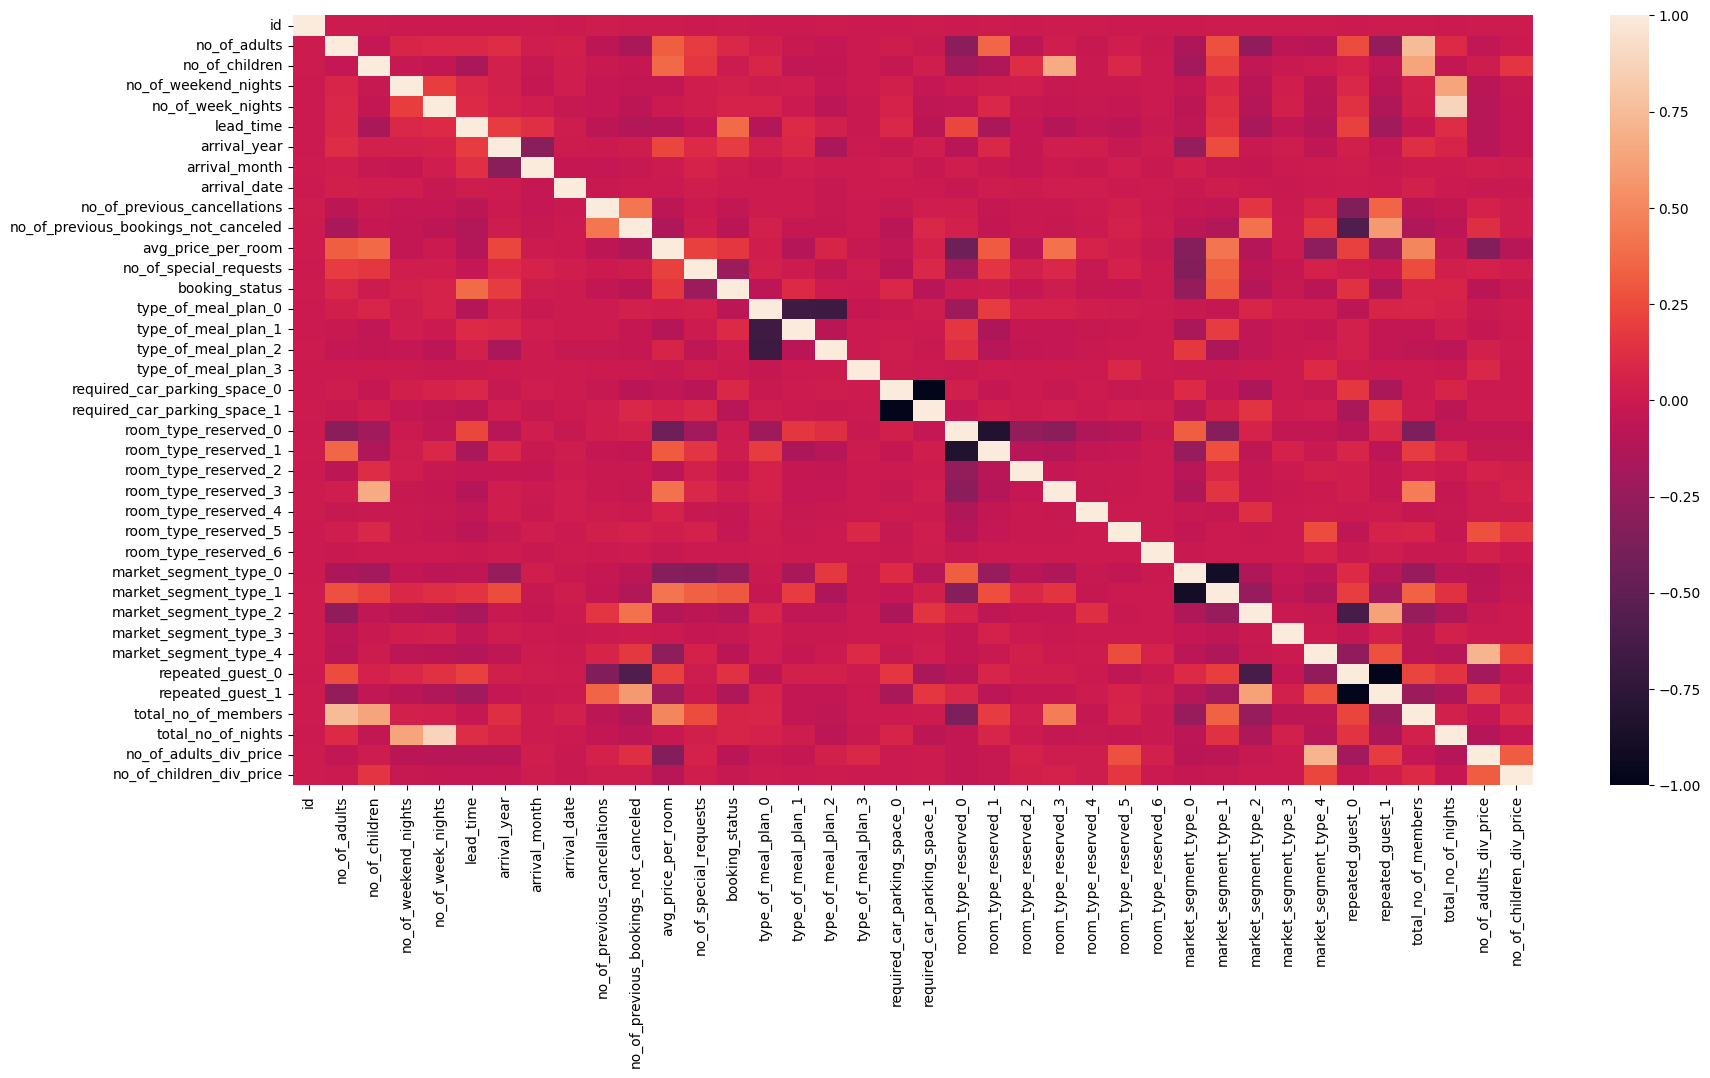

In [41]:
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr())
plt.show()

In [42]:
test['total_no_of_members'] = test['no_of_adults'] + test['no_of_children']
test['total_no_of_nights'] = test['no_of_weekend_nights'] + test['no_of_week_nights']
test['no_of_adults_div_price'] = test.no_of_adults / (test.avg_price_per_room + 1e-6)
test['no_of_children_div_price'] = test.no_of_children / (test.avg_price_per_room + 1e-6)

In [43]:
test.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1,total_no_of_members,total_no_of_nights,no_of_adults_div_price,no_of_children_div_price
0,42100,3,0,1,4,111,2018,12,5,0,0,115.60,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3,5,0.025952,0.000000
1,42101,2,0,0,3,22,2017,10,21,0,0,85.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.023529,0.000000
2,42102,2,2,0,1,18,2018,8,10,0,0,240.00,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4,1,0.008333,0.008333
3,42103,2,0,0,3,88,2018,5,30,0,0,80.75,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.024768,0.000000
4,42104,1,0,0,2,7,2018,9,21,0,0,144.00,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,2,0.006944,0.000000


In [44]:
train.shape, test.shape

((41334, 38), (28068, 37))

#### Seperating the dataset

In [45]:
Y = train['booking_status']
train.drop(columns=['id', 'booking_status'], inplace=True)

In [46]:
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1,total_no_of_members,total_no_of_nights,no_of_adults_div_price,no_of_children_div_price
0,2,0,0,2,9,2018,1,14,11,0,67.50,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,2,0.029630,0.0
1,2,0,1,2,117,2018,7,29,0,0,72.25,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.027682,0.0
2,2,0,0,1,315,2018,12,2,0,0,52.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.038462,0.0
3,1,0,0,2,32,2018,12,1,0,0,56.00,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,2,0.017857,0.0
4,2,0,1,0,258,2018,10,16,0,0,100.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.020000,0.0


In [47]:
test.drop(columns='id', inplace=True)

In [48]:
train.shape, Y.shape, test.shape

((41334, 36), (41334,), (28068, 36))

#### Mutual Information

In [49]:
from sklearn.feature_selection import mutual_info_classif

In [50]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [51]:
discrete_features = train.dtypes == "int64"

In [52]:
print(f"discrete_features boolean value:\n{discrete_features}")

discrete_features boolean value:
no_of_adults                             True
no_of_children                           True
no_of_weekend_nights                     True
no_of_week_nights                        True
lead_time                                True
arrival_year                             True
arrival_month                            True
arrival_date                             True
no_of_previous_cancellations             True
no_of_previous_bookings_not_canceled     True
avg_price_per_room                      False
no_of_special_requests                   True
type_of_meal_plan_0                     False
type_of_meal_plan_1                     False
type_of_meal_plan_2                     False
type_of_meal_plan_3                     False
required_car_parking_space_0            False
required_car_parking_space_1            False
room_type_reserved_0                    False
room_type_reserved_1                    False
room_type_reserved_2                    False
r

In [53]:
mi_scores = make_mi_scores(train, Y, discrete_features)

In [54]:
mi_scores

lead_time                               0.129933
avg_price_per_room                      0.103075
no_of_adults_div_price                  0.095195
market_segment_type_1                   0.048868
market_segment_type_0                   0.030917
no_of_special_requests                  0.028836
arrival_month                           0.028753
repeated_guest_0                        0.019311
arrival_year                            0.018264
repeated_guest_1                        0.014979
type_of_meal_plan_1                     0.013227
no_of_previous_bookings_not_canceled    0.012820
required_car_parking_space_0            0.011277
required_car_parking_space_1            0.006890
no_of_children_div_price                0.006270
total_no_of_members                     0.005643
no_of_adults                            0.005605
type_of_meal_plan_0                     0.005536
total_no_of_nights                      0.003944
market_segment_type_2                   0.003771
no_of_previous_cance

In [55]:
k_means_features = ['lead_time', 'avg_price_per_room', 'no_of_adults_div_price', 'market_segment_type_1', 'market_segment_type_0', 'no_of_special_requests', 
                    'arrival_month', 'repeated_guest_0', 'arrival_year', 'required_car_parking_space_0']

In [56]:
from sklearn.cluster import KMeans

In [57]:
kmeans_1 = KMeans(n_clusters=6)

In [58]:
kmeans_1.fit(train[k_means_features], Y)

KMeans(n_clusters=6)

In [59]:
train['cluster_6'] = kmeans_1.predict(train[k_means_features])

In [60]:
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1,total_no_of_members,total_no_of_nights,no_of_adults_div_price,no_of_children_div_price,cluster_6
0,2,0,0,2,9,2018,1,14,11,0,67.50,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,2,0.029630,0.0,0
1,2,0,1,2,117,2018,7,29,0,0,72.25,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.027682,0.0,0
2,2,0,0,1,315,2018,12,2,0,0,52.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.038462,0.0,5
3,1,0,0,2,32,2018,12,1,0,0,56.00,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,2,0.017857,0.0,0
4,2,0,1,0,258,2018,10,16,0,0,100.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.020000,0.0,5


In [61]:
train['cluster_6'] = train['cluster_6'].astype("int64")

In [62]:
discrete_features = train.dtypes == "int64"

In [63]:
mi_scores = make_mi_scores(train, Y, discrete_features)

In [64]:
train.shape, test.shape

((41334, 37), (28068, 36))

In [65]:
test['cluster_6'] = kmeans_1.predict(test[k_means_features])

In [66]:
train.shape, test.shape

((41334, 37), (28068, 37))

In [67]:
kmeans_2 = KMeans(n_clusters=7)

In [68]:
kmeans_2.fit(train[k_means_features], Y)

KMeans(n_clusters=7)

In [69]:
train['cluster_7'] = kmeans_2.predict(train[k_means_features])

In [70]:
train['cluster_7'] = train['cluster_7'].astype("int64")

In [71]:
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1,total_no_of_members,total_no_of_nights,no_of_adults_div_price,no_of_children_div_price,cluster_6,cluster_7
0,2,0,0,2,9,2018,1,14,11,0,67.50,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,2,0.029630,0.0,0,6
1,2,0,1,2,117,2018,7,29,0,0,72.25,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.027682,0.0,0,0
2,2,0,0,1,315,2018,12,2,0,0,52.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.038462,0.0,5,5
3,1,0,0,2,32,2018,12,1,0,0,56.00,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,2,0.017857,0.0,0,6
4,2,0,1,0,258,2018,10,16,0,0,100.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,0.020000,0.0,5,5


In [72]:
discrete_features = train.dtypes == "int64"

In [73]:
mi_scores = make_mi_scores(train, Y, discrete_features)

In [74]:
mi_scores

lead_time                               0.129933
avg_price_per_room                      0.102313
no_of_adults_div_price                  0.097365
cluster_7                               0.071020
cluster_6                               0.062674
market_segment_type_1                   0.048029
market_segment_type_0                   0.033644
no_of_special_requests                  0.028836
arrival_month                           0.028753
repeated_guest_0                        0.018575
arrival_year                            0.018264
no_of_previous_bookings_not_canceled    0.012820
repeated_guest_1                        0.010642
required_car_parking_space_0            0.009723
type_of_meal_plan_0                     0.006924
room_type_reserved_3                    0.006683
market_segment_type_4                   0.006644
total_no_of_members                     0.005643
no_of_adults                            0.005605
market_segment_type_2                   0.005172
no_of_children_div_p

In [75]:
test['cluster_7'] = kmeans_2.predict(test[k_means_features])

In [76]:
test.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1,total_no_of_members,total_no_of_nights,no_of_adults_div_price,no_of_children_div_price,cluster_6,cluster_7
0,3,0,1,4,111,2018,12,5,0,0,115.60,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3,5,0.025952,0.000000,0,0
1,2,0,0,3,22,2017,10,21,0,0,85.00,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.023529,0.000000,0,6
2,2,2,0,1,18,2018,8,10,0,0,240.00,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4,1,0.008333,0.008333,0,6
3,2,0,0,3,88,2018,5,30,0,0,80.75,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,3,0.024768,0.000000,0,0
4,1,0,0,2,7,2018,9,21,0,0,144.00,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,2,0.006944,0.000000,0,6


In [77]:
test[['cluster_6', 'cluster_7']] = test[['cluster_6', 'cluster_7']].astype("int64")

In [78]:
test.shape, train.shape, Y.shape

((28068, 38), (41334, 38), (41334,))

In [79]:
numerical_features = [feature for feature in train.columns if feature != 'cluster_6' and feature != 'cluster_7']

In [80]:
len(numerical_features), train.shape[1]

(36, 38)

#### Scaling

In [81]:
from sklearn.preprocessing import RobustScaler

In [82]:
scaler = RobustScaler().fit(train[numerical_features])

In [83]:
train[numerical_features] = scaler.transform(train[numerical_features])

In [84]:
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan_0,type_of_meal_plan_1,type_of_meal_plan_2,type_of_meal_plan_3,required_car_parking_space_0,required_car_parking_space_1,room_type_reserved_0,room_type_reserved_1,room_type_reserved_2,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,market_segment_type_0,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_0,repeated_guest_1,total_no_of_members,total_no_of_nights,no_of_adults_div_price,no_of_children_div_price,cluster_6,cluster_7
0,0.0,0.0,-0.5,0.0,-0.703390,0.0,-1.75,-0.1250,11.0,0.0,-0.737875,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.5,1.209283,0.0,0,6
1,0.0,0.0,0.0,0.0,0.211864,0.0,-0.25,0.8125,0.0,0.0,-0.628176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.982754,0.0,0,0
2,0.0,0.0,-0.5,-0.5,1.889831,0.0,1.00,-0.8750,0.0,0.0,-1.095843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,2.236345,0.0,5,5
3,-1.0,0.0,-0.5,0.0,-0.508475,0.0,1.00,-0.9375,0.0,0.0,-1.003464,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.5,-0.159739,0.0,0,6
4,0.0,0.0,0.0,-1.0,1.406780,0.0,0.50,0.0000,0.0,0.0,0.012702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.089454,0.0,5,5


In [85]:
test[numerical_features] = scaler.transform(test[numerical_features])

In [86]:
train.shape, test.shape, Y.shape

((41334, 38), (28068, 38), (41334,))

#### Model

In [98]:
from xgboost import XGBClassifier

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [100]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [101]:
different_model = RandomizedSearchCV(XGBClassifier(n_jobs=-1, n_estimators=1000, random_state=10), {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                                                                                    'learning_rate': [0.0001, 0.001, 0.1, 0.15, 0.2, 0.25, 0.3],
                                                                                                    'min_child_weight' : [1, 3, 5, 7, 9, 11, 13, 15],
                                                                                                    }, cv=skfold, return_train_score=False, scoring='roc_auc', n_iter=15)

In [102]:
different_model.fit(train, Y)
pd.DataFrame(different_model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,10.038557,0.058346,0.029632,0.000531,5,4,0.15,"{'min_child_weight': 5, 'max_depth': 4, 'learn...",0.903297,0.903558,0.906267,0.901598,0.908423,0.904628,0.002416,1
5,8.044482,0.025497,0.024842,0.000753,1,3,0.15,"{'min_child_weight': 1, 'max_depth': 3, 'learn...",0.902430,0.902294,0.905885,0.902888,0.909313,0.904562,0.002713,2
7,12.794462,0.080009,0.038313,0.001776,9,5,0.1,"{'min_child_weight': 9, 'max_depth': 5, 'learn...",0.902902,0.902778,0.906394,0.901385,0.907906,0.904273,0.002456,3
11,8.468968,0.030977,0.025314,0.001274,15,3,0.1,"{'min_child_weight': 15, 'max_depth': 3, 'lear...",0.901140,0.901813,0.905469,0.901626,0.907698,0.903549,0.002585,4
4,5.852197,0.031318,0.020598,0.000626,1,2,0.3,"{'min_child_weight': 1, 'max_depth': 2, 'learn...",0.901829,0.900864,0.904496,0.901151,0.908134,0.903295,0.002739,5
9,6.125315,0.044304,0.020704,0.000605,13,2,0.25,"{'min_child_weight': 13, 'max_depth': 2, 'lear...",0.900983,0.900841,0.904350,0.900820,0.907732,0.902945,0.002745,6
1,13.457852,0.365814,0.040814,0.002361,11,6,0.25,"{'min_child_weight': 11, 'max_depth': 6, 'lear...",0.895516,0.896131,0.898936,0.895235,0.900841,0.897332,0.002192,7
6,17.306407,0.201702,0.049895,0.001391,13,7,0.25,"{'min_child_weight': 13, 'max_depth': 7, 'lear...",0.892602,0.892712,0.896732,0.890728,0.897061,0.893967,0.002496,8
0,48.742447,1.581604,0.132574,0.038450,11,10,0.001,"{'min_child_weight': 11, 'max_depth': 10, 'lea...",0.886576,0.888099,0.889585,0.887319,0.891440,0.888604,0.001733,9
10,26.599252,5.580606,0.063755,0.002794,15,8,0.001,"{'min_child_weight': 15, 'max_depth': 8, 'lear...",0.882572,0.885539,0.885602,0.884942,0.888228,0.885376,0.001804,10


In [103]:
different_model.best_params_

{'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15}

In [104]:
final_model = XGBClassifier(n_jobs=-1, n_estimators=1000, random_state=42, max_depth=4, learning_rate=0.15, min_child_weight=5)

In [105]:
final_model.fit(train, Y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [106]:
test_prediction = final_model.predict_proba(test)[:, 1]

In [107]:
submission['booking_status'] = test_prediction

In [108]:
submission.to_csv('./Data/sample_submission.csv', index=False)

#### Train test split

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(train, Y, test_size=0.15)

In [111]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((35133, 38), (35133,), (6201, 38), (6201,))

In [112]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [113]:
train_prediction_metric = final_model.predict(X_train)

In [114]:
print(accuracy_score(train_prediction_metric, Y_train))
print(classification_report(train_prediction_metric, Y_train))
print(confusion_matrix(train_prediction_metric, Y_train))

0.8727407280903994
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     21813
           1       0.82      0.85      0.83     13320

    accuracy                           0.87     35133
   macro avg       0.86      0.87      0.87     35133
weighted avg       0.87      0.87      0.87     35133

[[19406  2407]
 [ 2064 11256]]


In [115]:
test_prediction_metric = final_model.predict(X_test)

In [116]:
print(accuracy_score(test_prediction_metric, Y_test))
print(classification_report(test_prediction_metric, Y_test))
print(confusion_matrix(test_prediction_metric, Y_test))

0.8713110788582487
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3811
           1       0.82      0.85      0.84      2390

    accuracy                           0.87      6201
   macro avg       0.86      0.87      0.86      6201
weighted avg       0.87      0.87      0.87      6201

[[3379  432]
 [ 366 2024]]


## Final Score after submission
<img src='./Screenshot (488).png'>

#### Storing all the models as .pkl files

In [117]:
import pickle

In [121]:
# Saving the one hot encoding model
pickle.dump(encoder, open('./Model/encoder.pkl', 'wb'))

In [122]:
# Saving the cluster_6 model
pickle.dump(kmeans_1, open('./Model/kmeans_1.pkl', 'wb'))

In [123]:
# Saving the cluster_7 model
pickle.dump(kmeans_2, open('./Model/kmeans_2.pkl', 'wb'))

In [124]:
# Saving the scaler model
pickle.dump(scaler, open('./Model/scaler.pkl', 'wb'))

In [125]:
# Saving the predicting model
pickle.dump(final_model, open('./Model/final_model.pkl', 'wb'))